# Laboratorium 01 — Wprowadzenie do analizy obrazów medycznych (DICOM i NIfTI)

W tym laboratorium rozpoczniemy pracę z medycznymi danymi obrazowymi. Poznamy podstawowe formaty (DICOM, NIfTI), sposoby wczytywania i eksploracji wolumenów 3D, przegląd najważniejszych metadanych oraz wykonamy proste przekształcenia i wizualizacje.

## Cele nauczania
- Zrozumienie różnic między formatami DICOM i NIfTI oraz kiedy ich używać.
- Wczytywanie obrazów z użyciem bibliotek: pydicom, SimpleITK, nibabel, nilearn.
- Odczyt i interpretacja metadanych.
- Podstawowe operacje na danych 3D: wybór przekrojów, progowanie, obliczanie gradientów (Sobel), przepróbkowanie (interpolacja danych).
- Przegląd i zapis danych do plików NIfTI.

## Zakres i przepływ pracy
1. DICOM: wczytanie pojedynczych plików, przegląd nagłówka i pikseli (pydicom, SimpleITK)
2. NIfTI: wczytanie wolumenu, macierz affine, orientacje, podstawowe przekroje (nibabel)
3. Wizualizacja 2D/3D: przekroje osiowe/koronalne/strzałkowe, proste układy figur (matplotlib, opcjonalnie nilearn)
4. Proste przekształcenia: progowanie, filtr Sobela 3D, filtracja medianowa
5. Resamplowanie i zapis: izotropizacja voxeli, zapis przetworzonych danych do NIfTI

## Dane do ćwiczeń
Dane powinny pobrać się automatycznie w ramach skryptu. Znajdują się one w folderze data lub /content/data (w przypadku Google Colab).

## Wymagane narzędzia i biblioteki
- Python 3.9+ oraz:
  - numpy, matplotlib
  - pydicom, SimpleITK
  - nibabel, nilearn
- Biblioteki należy zainstalować na początku skryptu jeśli pracujesz w Google Colab. Jeśli pracujesz lokalnie, to warto stworzyć środowisko conda lub venv.

## Typowe pułapki i wskazówki
- Orientacje i układy współrzędnych: DICOM zwykle używa LPS, wiele narzędzi neuro (nibabel/nilearn) preferuje RAS. Nie mieszaj konwencji bez kontroli affine.
- Jednostki i skale intensywności: CT (HU - Hounsfield Units) vs MR (wartości względne). Normalizuj lub standaryzuj dane przed progowaniem/filtracją.
- Spójny spacing: przed analizą porównawczą rozważ resamplowanie do voxeli izotropowych (np. 1×1×1 mm).
- Pamięć i wydajność: pracujemy na małych przykładach, ale na większych danych stosuje się lazy loading (dane nie są wczytywane od razu, tylko po wywołaniu), ogranicza rozmiar figur i liczbę kopii tablic.

Powodzenia! W kolejnych sekcjach przejdziemy od wczytania plików po zapis przetworzonych wolumenów i krótką analizę.

## 0) Instalacja bibliotek (jeśli potrzebne)

In [ ]:
# Uruchom, jeśli pojawi się błąd 'ModuleNotFoundError'
!pip -q install scipy nibabel nilearn SimpleITK pydicom matplotlib numpy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.7/12.7 MB 110.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.6/52.6 MB 16.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 32.8 MB/s eta 0:00:00



## 1) Automatyczne pobranie przykładowych danych

Aby nie trzeba było samodzielnie uploadować danych, wczytamy:
- **DICOM**: przykładowe pliki z pakietu `pydicom` (CT, MR),
- **NIfTI**: mały wolumen MNI152 (szablon MRI mózgu) pobrany z `nilearn`.


In [ ]:
import os, shutil, urllib.request
import numpy as np
import matplotlib.pyplot as plt

import nibabel as nib
import SimpleITK as sitk
import pydicom
from pydicom.data import get_testdata_files

from scipy import ndimage as ndi

BASE = "/content/data" if os.path.isdir("/content") else "./data"
DATA_DIR = os.path.join(BASE, "lab01_data")
os.makedirs(DATA_DIR, exist_ok=True)

# --- DICOM ---
dicom_dir = os.path.join(DATA_DIR, "dicom")
os.makedirs(dicom_dir, exist_ok=True)

dicom_examples = ["CT_small.dcm", "MR_small.dcm", "SC_rgb.dcm"]
for name in dicom_examples:
    src = get_testdata_files(name)[0]
    dst = os.path.join(dicom_dir, name)
    shutil.copy(src, dst)
print("Skopiowano pliki DICOM:", os.listdir(dicom_dir))

# --- NIfTI ---
nifti_dir = os.path.join(DATA_DIR, "nifti")
os.makedirs(nifti_dir, exist_ok=True)

nifti_path = os.path.join(nifti_dir, "mni152.nii.gz")
try:
    from nilearn.datasets import load_mni152_template
    img = load_mni152_template(resolution=2)
    nib.save(img, nifti_path)
    print("Pobrano MNI152 przez nilearn:", nifti_path)
except Exception as e:
    print("Błąd nilearn:", e)
    url = "https://nipy.org/nibabel/_static/nifti_examples/nifti1.nii.gz"
    urllib.request.urlretrieve(url, nifti_path)
    print("Pobrano fallback NIfTI:", nifti_path)

print("Gotowe dane w:", DATA_DIR)


Skopiowano pliki DICOM: ['CT_small.dcm', 'SC_rgb.dcm', 'MR_small.dcm']
Pobrano MNI152 przez nilearn: /content/data/lab01_data/nifti/mni152.nii.gz
Gotowe dane w: /content/data/lab01_data



## Zadanie 1 – Wczytanie obrazu DICOM i metadane

1. Wykonaj ponizsze operacje dla każdego z pobranych plików testowych DICOM (nazwy w `dicom_examples`).
2. Metadane mogą być wczytane zarówno za pomocą biblioteki `pydicom` jak i `SimpleITK`.
3. Najpierw wczytaj plik za pomocą funkcji `pydicom.dcmread`.
4. Następnie wczytaj i wyświetl za pomocą funkcji `getattr` metadane takie jak: `"Modality", "Rows", "Columns", "PixelSpacing", "SliceThickness", "Manufacturer"`.
Przykład wczytania przykładowej wartości: `print("Photometric Interpretation:", getattr(img_dcm_pydicom, "PhotometricInterpretation", "brak"))`.
5. Wczytaj ten sam plik za pomocą funkcji `sitk.ReadImage`.
6. Wypisz wszystkie dostępne metadane dostępne w plikach. W tym celu wykorzystaj funkcji `img.GetMetaDataKeys()` oraz `img_dcm.GetMetaData(key)`.
7. Przeanalizuj dostępne metadane.
8. Wczytaj dane obrazowe za pomocą funkcji `sitk.GetArrayFromImage`, a następnie wyświetl dane za pomocą `matplotlib`.

In [ ]:
# --- Zadanie 1

for f_name in dicom_examples:
  file_ds = pydicom.dcmread(os.path.join(dicom_dir, f_name))
  print(f_name)
  print(getattr(file_ds, "Modality", "Brak danych!"))
  print(getattr(file_ds, "Rows", "Brak danych!"))
  print(getattr(file_ds, "Columns", "Brak danych!"))
  print(getattr(file_ds, "PixelSpacing", "Brak danych!"))
  print(getattr(file_ds, "SliceThickness", "Brak danych!"))
  print(getattr(file_ds, "Manufacturer", "Brak danych!"))
  print()

CT_small.dcm
CT
128
128
[0.661468, 0.661468]
5.000000
GE MEDICAL SYSTEMS

MR_small.dcm
MR
64
64
[0.3125, 0.3125]
0.8000
TOSHIBA_MEC

SC_rgb.dcm
OT
100
100
[1.0, 1.0]
Brak danych!
Brak danych!



CT_small.dcm
0008|0005: ISO_IR 100
0008|0008: ORIGINAL\PRIMARY\AXIAL
0008|0012: 20040119
0008|0013: 072731
0008|0014: 1.3.6.1.4.1.5962.3
0008|0016: 1.2.840.10008.5.1.4.1.1.2
0008|0018: 1.3.6.1.4.1.5962.1.1.1.1.1.20040119072730.12322
0008|0020: 20040119
0008|0021: 19970430
0008|0022: 19970430
0008|0023: 19970430
0008|0030: 072730
0008|0031: 112749
0008|0032: 112936
0008|0033: 113008
0008|0050: 
0008|0060: CT
0008|0070: GE MEDICAL SYSTEMS
0008|0080: JFK IMAGING CENTER
0008|0090: 
0008|0201: -0500 
0008|1010: CT01_OC0
0008|1030: e+1 
0008|1090: RHAPSODE
0010|0010: CompressedSamples^CT1 
0010|0020: 1CT1
0010|0030: 
0010|0040: O 
0010|1010: 000Y
0010|1030: 0.000000
0010|21b0: 
0018|0010: ISOVUE300/100 
0018|0022: HELICAL MODE
0018|0050: 5.000000
0018|0060: 120 
0018|0088: 5.000000
0018|0090: 480.000000
0018|1020: 05
0018|1040: IV
0018|1100: 338.671600
0018|1110: 1099.3100585938 
0018|1111: 630.000000
0018|1120: 0.000000
0018|1130: 133.699997
0018|1150: 1601
0018|1151: 170 
0018|1152: 170 
0

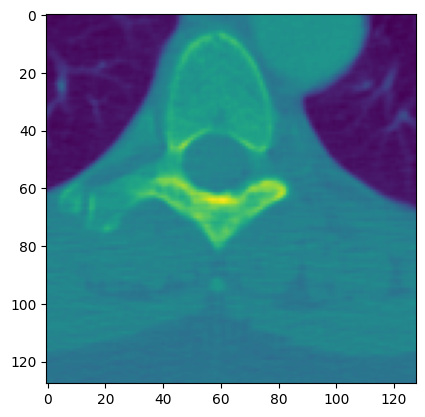

MR_small.dcm
0008|0008: DERIVED\SECONDARY\OTHER 
0008|0012: 20040826
0008|0013: 185434
0008|0014: 1.3.6.1.4.1.5962.3
0008|0016: 1.2.840.10008.5.1.4.1.1.4
0008|0018: 1.3.6.1.4.1.5962.1.1.4.1.1.20040826185059.5457
0008|0020: 20040826
0008|0021: 
0008|0022: 
0008|0030: 185059
0008|0031: 
0008|0032: 
0008|0050: 
0008|0060: MR
0008|0070: TOSHIBA_MEC 
0008|0080: TOSHIBA 
0008|0090: 
0008|0201: -0400 
0008|1010: 000000000 
0008|1060: ----
0008|1070: ----
0008|1090: MRT50H1 
0010|0010: CompressedSamples^MR1 
0010|0020: 4MR1
0010|0030: 
0010|0040: F 
0010|1020: 
0010|1030: 80.0000 
0018|0010: 
0018|0020: SE
0018|0021: NONE
0018|0022: 
0018|0023: 3D
0018|0050: 0.8000
0018|0080: 4000.0000 
0018|0081: 240.0000
0018|0083: 1.0000
0018|0084: 63.92433900 
0018|0085: H 
0018|0086: 1 
0018|0091: 
0018|1000: -0000200
0018|1020: V3.51*P25 
0018|1314: 90
0018|5100: HFS 
0020|000d: 1.3.6.1.4.1.5962.1.2.4.20040826185059.5457
0020|000e: 1.3.6.1.4.1.5962.1.3.4.1.20040826185059.5457
0020|0010: 4MR1
0020|0011: 1

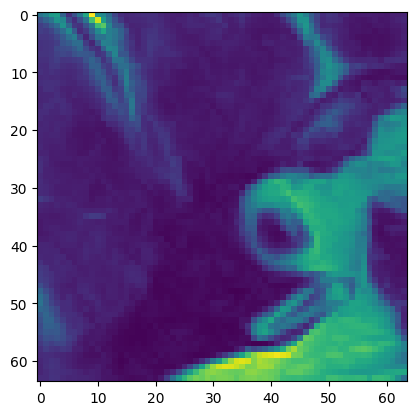

SC_rgb.dcm
0008|0005: ISO_IR 192
0008|0008: DERIVED\SECONDARY\OTHER 
0008|0016: 1.2.840.10008.5.1.4.1.1.7
0008|0018: 1.2.826.0.1.3680043.8.498.49043964482360854182530167603505525116
0008|0020: 20170101
0008|0023: 
0008|002a: 
0008|0030: 120000
0008|0033: 
0008|0050: 
0008|0060: OT
0008|0064: SYN 
0008|0090: Moriarty^James
0010|0010: Lestrade^G
0010|0020: ID1 
0010|0030: 
0010|0040: F 
0010|1010: 024Y
0018|5100: 
0020|000d: 1.2.826.0.1.3680043.8.498.12406831542731051035295345080039845114
0020|000e: 1.2.826.0.1.3680043.8.498.16157229083793556332623330502397121062
0020|0010: 1 
0020|0011: 1 
0020|0013: 1 
0020|0020: 
0020|0060: 
0020|4000: Test Image with 10 rows of (255,0,0), 10 rows of (255,128,128), 10 rows of (0,255,0), 10 rows of (128,255,128), 10 rows of (0,0,255), 10 rows of (128,128,255), 10 rows of (0,0,0), 10 rows of (64,64,64), 10 rows of (192,192,192), 10 rows of (255,255,255), uncompressed 
0028|0002: 3
0028|0004: RGB 
0028|0006: 0
0028|0010: 100
0028|0011: 100
0028|0030: 1.0

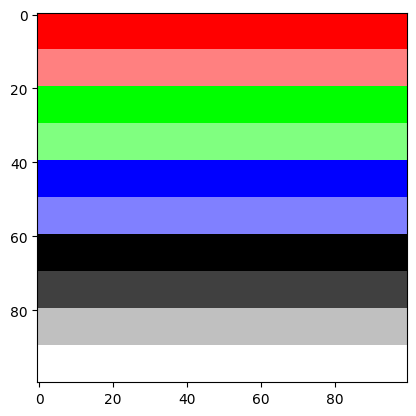

In [ ]:
for f_name in dicom_examples:
  print(f_name)
  image = sitk.ReadImage(os.path.join(dicom_dir, f_name))
  keys = image.GetMetaDataKeys()
  for key in keys:
    value = image.GetMetaData(key)
    print(f"{key}: {value}")


  array = sitk.GetArrayFromImage(image)[0]
  plt.imshow(array, cmap="gray")
  plt.show()

print()


## Zadanie 2 – Wczytanie wolumenu NIfTI i przekroje

1. Wczytaj plik `mni152.nii.gz`. Ścieżka znajduje się w `nifti_path`. Wykorzystaj funkcję `nib.load`.
2. Wczytaj dane za pomocą funkcji `file.get_fdata()`.
3. Sprawdź kształt tablicy (`data.shape`), macierz affine (`file.affine`), spacing (`file.header.get_zooms()`) oraz kierunek osi `nib.aff2axcodes(nii.affine)`.
4. Wyświetl trzy środkowe przekroje: axial (poprzeczny - "od góry"), coronal (czołowy - "od przodu"), sagittal (strzałkowy - "od boku").


(99, 117, 95)
[[   2.    0.    0.  -98.]
 [   0.    2.    0. -134.]
 [   0.    0.    2.  -72.]
 [   0.    0.    0.    1.]]
(np.float32(2.0), np.float32(2.0), np.float32(2.0))


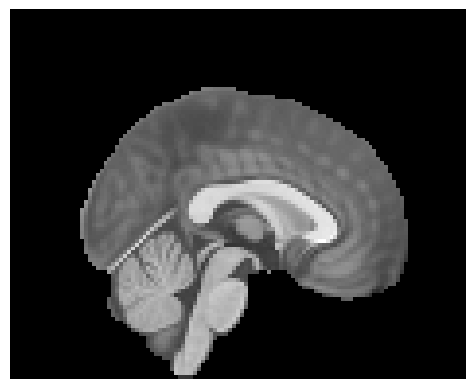

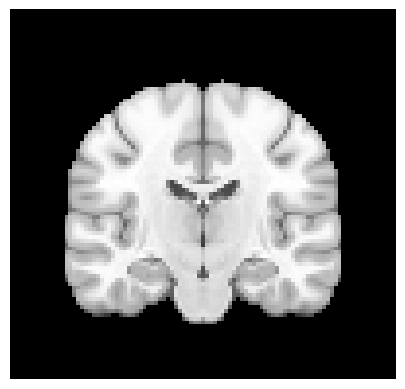

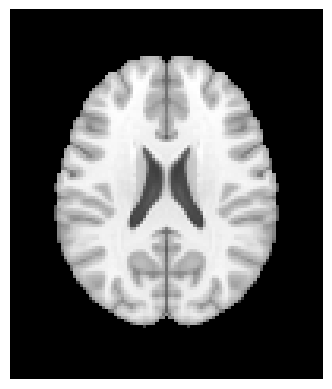

In [ ]:
# --- Zadanie 2

gz_file = nib.load(nifti_path)
gz_data = gz_file.get_fdata()

print(gz_data.shape)
print(gz_file.affine)
print(gz_file.header.get_zooms())
nib.aff2axcodes(gz_file.affine)

z, y, x = gz_data.shape

z_section = np.rot90(gz_data[z // 2, :, :])
y_section = np.rot90(gz_data[:, y // 2, :])
x_section = np.rot90(gz_data[:, :, x // 2])

plt.imshow(z_section, cmap="gray")
plt.axis('off')
plt.show()
plt.imshow(y_section, cmap="gray")
plt.axis('off')
plt.show()
plt.imshow(x_section, cmap="gray")
plt.axis('off')
plt.show()


## Zadanie 3 – Histogram i podstawowe operacje

1. Wyświetl histogram intensywności wolumenu (NIfTI) za pomocą funkcji `plt.hist`. W celu poprawy widoczności można ustawić `range=(0.01, 1)`. Wcześniej spłaszcz dane za pomocą metody `.ravel()`.
2. Wyświetl 3 oryginalne przekroje (jak w poprzednim zadaniu).
3. Oblicz gradient Sobela względem wszystkich trzech osi. Wykorzystaj funkcję `ndi.sobel`.
4. Za pomocą normy L2 połącz wyniki z wszystkich osi.
5. Wyświetl te same przekroje jak wcześniej.
6. Wykonaj progowanie dla 90-tego precentyla danych. Do wyznaczenia tej wartości wykorzystaj funkcję `np.percentile`.
7. Wykonaj progowania, a następnie zrzutuj wynik do typu `np.uint8`.
8. Wyświetl te same przekroje jak wcześniej.
9. Wykonaj filtrację medianową dla tych samych danych. Wykorzystaj funkcję `ndi.median_filter`.
10. Wyświetl te same przekroje jak wcześniej.


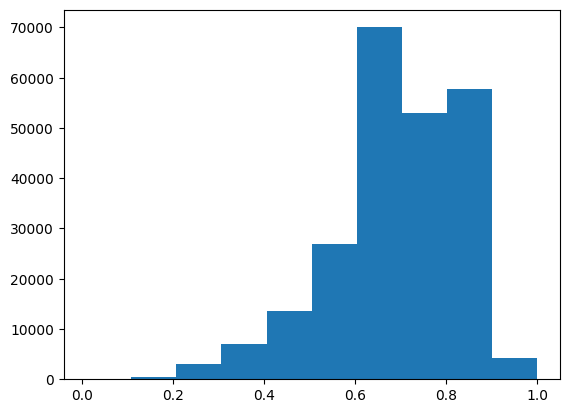

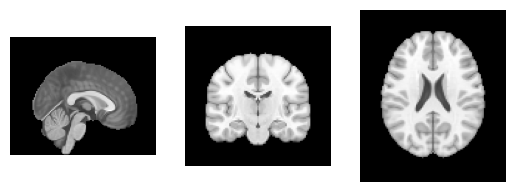

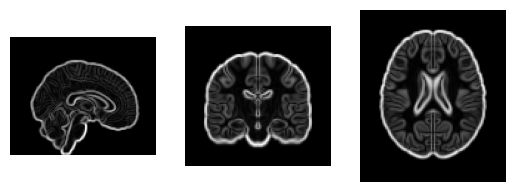

0.7098039388656616


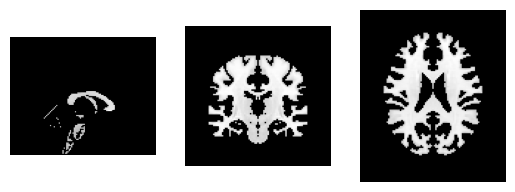

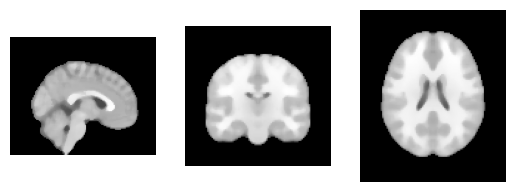

In [ ]:
# --- Zadanie 3
plt.hist(gz_data.ravel(), range=(0.01, 1))

_, axs = plt.subplots(1, 3)
axs[0].imshow(z_section, cmap='gray')
axs[0].axis('off')
axs[1].imshow(y_section, cmap='gray')
axs[1].axis('off')
axs[2].imshow(x_section, cmap='gray')
axs[2].axis('off')
plt.show()

sobel_z = ndi.sobel(gz_data, 0)
sobel_y = ndi.sobel(gz_data, 1)
sobel_x = ndi.sobel(gz_data, 2)

sobel_norm = np.sqrt(sobel_x ** 2 + sobel_y ** 2 + sobel_z ** 2)
# print(sobel_norm)

z_section_s = np.rot90(sobel_norm[z // 2, :, :])
y_section_s = np.rot90(sobel_norm[:, y // 2, :])
x_section_s = np.rot90(sobel_norm[:, :, x // 2])

_, axs = plt.subplots(1, 3)
axs[0].imshow(z_section_s, cmap='gray')
axs[0].axis('off')
axs[1].imshow(y_section_s, cmap='gray')
axs[1].axis('off')
axs[2].imshow(x_section_s, cmap='gray')
axs[2].axis('off')
plt.show()

thresh = np.percentile(gz_data, 90)
print(thresh)

data_thresh = (gz_data * (gz_data > thresh) * 255).astype(np.uint8)

z_section_t = np.rot90(data_thresh[z // 2, :, :])
y_section_t = np.rot90(data_thresh[:, y // 2, :])
x_section_t = np.rot90(data_thresh[:, :, x // 2])

_, axs = plt.subplots(1, 3)
axs[0].imshow(z_section_t, cmap='gray')
axs[0].axis('off')
axs[1].imshow(y_section_t, cmap='gray')
axs[1].axis('off')
axs[2].imshow(x_section_t, cmap='gray')
axs[2].axis('off')
plt.show()

filtered_data = ndi.median_filter(gz_data, size=5)

z_section_f = np.rot90(filtered_data[z // 2, :, :])
y_section_f = np.rot90(filtered_data[:, y // 2, :])
x_section_f = np.rot90(filtered_data[:, :, x // 2])

_, axs = plt.subplots(1, 3)
axs[0].imshow(z_section_f, cmap='gray')
axs[0].axis('off')
axs[1].imshow(y_section_f, cmap='gray')
axs[1].axis('off')
axs[2].imshow(x_section_f, cmap='gray')
axs[2].axis('off')
plt.show()




## Zadanie 4 – Resampling wolumenu do izotropowego voxela

1. Wczytaj dane NIfTI za pomocą `SimpleITK`. Wykorzystaj funkcję `sitk.ReadImage`.
2. Wyświetl rozmiar i spacing wczytanych danych. Wykorzystaj metody `.GetSize()` i `.GetSpacing()`.
3. Stwórz instancję klasy `sitk.ResampleImageFilter()`.
4. Wybierz metodę interpolacji za pomocą metody `.SetInterpolator`.
5. Wybierz wyjściowy spacing za pomocą metody `.SetOutputSpacing`. Chcemy uzyskać spacing 1mm dla każdej osi.
6. Ustaw orientację i położenie początka ukłądu współrzędnych jak w oryginalnych danych. Wykorzystaj metody `.SetOutputDirection`, `.GetDirection`, `.SetOutputOrigin` i `.GetOrigin`.
7. Oblicz rozmiar wyjściowych danych. Rozmiar dla analizowanego wymiaru powinien wynosić $Sz_o \cdot Sp_o / Sp_n$, gdzie $Sz_o$ jest originalnym rozmiarem, $Sp_o$ jest oryginalnym spacingiem, a $Sp_n$ jest docelowym spacingiem.
8. Ustaw docelowy rozmiar za pomocą metody `.SetSize`.
9. Wykonaj przeprobkowanie danych za pomocą metody `.Execute`.
10. Wyświetl rozmiar oraz spacing wyjściowych danych.

In [ ]:
# --- Zadanie 4


## Zadanie 5 – Zapis przetworzonego wolumenu w formacie NIfTI (LPS -> RAS)

1. Utwórz ścieżkę gdzie dane zostaną zapisane.
2. Wyciągnij dane `NumPy` z obrazu `SimpleITK`.
3. Dopasuj kolejność wymiarów do biblioteki `nibabel` - (z, y, x) -> (x, y, z). Wykorzystaj funkcję `np.transpose`.
4. Pobierz spacing, direction i origin dla zapisywanych danych. Zamień je na `np.array` typu `float`. Zmień kształt direction na `(3, 3)` metodą `.reshape`.
5. Wyświetl pobrane wartości.
6. Najpierw stwórz macierz affine dla formatu LPS (stosowany w `SimpleITK` i DICOM). Zacznij od stworzenia macierzy jednostkowej o rozmiarze $4 \times 4$. Następnie w trzy pierwsze kolumny i wiersze wpisz kolumny direction przeskalowane przez spacing (wystarczy operacja mnożenia element przez element - `*`). Do trzech pierwszych wierszy ostatniej kolumny wpisz origin.
7. Skonwertuj affine w formacie LPS do formatu RAS. W tym celu wystarczy odwrócić kierunki osi x i y. Można to zrobić wykonująć mnożenie macierzowe formatu lps przez macierz diagonalną o wartościach `[-1, -1, 1, 1]`. macierz diagonalną można stworzyć za pomocą `np.diag`.
8. Wyświetl obliczone affine. Porównaj go z affine oryginalnych danych, wczytanych na początku zadania 2.
9. Stwórz obraz NIfTI za pomocą `nib.Nifti1Image`. Pierwszym argumentem są dane jako tablica `NumPy`, a drugim affine w formacie RAS.
10. Wykonaj dodatkowo `nifti.set_sform(affine_ras, code=1)` i `nifti.set_qform(affine_ras, code=1)`.
11. Zapisz dane za pomocą `nib.save`.

In [ ]:
# --- Zadanie 5


---
## Podsumowanie (do krótkiego uzupełnienia)

- Jakie są główne różnice między DICOM a NIfTI?  
- Jakie metadane są ważne przy pracy z obrazami medycznymi?  
- Jak interpretować trzy podstawowe przekroje wolumenu (axial, coronal, sagittal)?
